# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt
import nolds

# from PreprocessFcns import gen_clips, powerspectra

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.21.0'

In [3]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
path = r'X:\CIS-PD Study\Subjects' #Windows remote path
#---------------------------------------------------------------------------------------------------------
folder_path = r'X:\CIS-PD Study' #generic Windows repo path

#Path where dictionary subject data is stored
#dict_path = 'D:\CIS-PD Study\Data_dict_noErr' #remote repo
dict_path = 'X:\CIS-PD Study\Data_dict'
# dict_path = '../Data_dict' # Mac local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

scores_path = r'X:\CIS-PD Study\Scores' #remote repo
# scores_path = '../Scores/' # Mac local path

#path where feature matrix is saved
features_path = r'X:\CIS-PD Study\FeatureMatrix' #remote repo
# features_path = '../FeatureMatrix' # Mac local path
# features_path = r'C:\Users\adai\Documents\FeatureMatrix' #Windows local path adai


In [4]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])

complete_temp = complete
complete_temp.remove('MDS-UPDRS #11: Rest Tremor')


def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    del df['Value']
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    return df

## Helper fcns

In [5]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    timestamps = fix_errors(SubID, timestamps)
    
    reverse_sensors_1024 = list(['anterior_thigh_left', 'anterior_thigh_right',
                                 'distal_lateral_shank_left', 'distal_lateral_shank_right'])
    # Hard coded list of sensors needed to be reversed in X- and Y- accel/gyro Day 1 data for Subject 1024
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Temporary fix for missing activities, added 10/10/2017 will remove once error functions are finished
    if SubID in ('1024', '1030', '1032'):
        complete_acts = complete_temp
    else:
        complete_acts = complete
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (len(startTimestamp)-1):
                        data['accel'].loc[:, ('Accel X (g)')] = -1*data['accel'].loc[:, ('Accel X (g)')]
                        data['accel'].loc[:, ('Accel Y (g)')] = -1*data['accel'].loc[:, ('Accel Y (g)')]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (len(startTimestamp)-1):
                        data['gyro'].loc[:, ('Gyro X (°/s)')] = -1*data['gyro'].loc[:, ('Gyro X (°/s)')]
                        data['gyro'].loc[:, ('Gyro Y (°/s)')] = -1*data['gyro'].loc[:, ('Gyro Y (°/s)')]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps


                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    

#extract clips for accelerometer and gyro data
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False,startTS=0,endTS=1):
    
    clip_data = {} #the dictionary with clips
    #params
    len_tol = 0.8   #% of the intended clipsize below which clip is not used

    for trial in act_dict[task].keys():
        clip_data[trial] = {}            

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #choose to create clips only on a fraction of the data (0<[startTS,endTS]<1)
            if (startTS > 0) | (endTS < 1):
                rawdata = rawdata.iloc[round(startTS*len(rawdata)):round(endTS*len(rawdata)),:]
                #reindex time (relative to start)
                idx = rawdata.index
                idx = idx-idx[0]
                rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
            clips = []
            for i in idx:
                c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                    clips.append(c)
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data


#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin
#if binavg is True it averages the PSD within bins to reduce PSD noise
def powerspectra(x,fm,fM,nbins=10,relative=False,binavg=True):
    
    #feature labels
    labels=[]
    s = np.linspace(fm,fM,nbins)
    lax = ['X','Y','Z']
    for l in lax:
        for i in s:
            labels.append('fft'+l+str(int(i)))
            
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
    
    #power spectra between fm-fM Hz
    bin1 = int(timestep*n*fm)
    bin2 = int(timestep*n*fM)
    bins = np.linspace(bin1,bin2,nbins,dtype=int)
#     print(bins/(round(timestep*n)))

    #average power spectra within bins
    if binavg:
        deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
        Pxxm = []
        for i in bins:
            start = int(max(i-deltab,bins[0]))
            end = int(min(i+deltab,bins[-1]))
            Pxxm.append(np.mean(Pxx.iloc[start:end,:].values,axis=0))            
        Pxxm = np.asarray(Pxxm)
        Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
        return Pxx, labels
    
    else:
        return Pxx.iloc[bins,:], labels


#extract features from both sensors (accel and gyro) for current clips and trials
#input: dictionary of clips from each subject
#output: feature matrix from all clips from given subject and scores for each clip
def feature_extraction(clip_data):
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','sEntX','sEntY','sENZ','sEnFFTX','sEnFFTy','sEnFFTz']
    
    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]
#                 print(rawdata.head(3))
                
                #extract features on current clip
                
                #Energy of signal on each axis
                E = np.asarray(np.sum(rawdata**2,axis=0))
                
                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)
            
                #Moments on each axis
                mean = np.asarray(np.mean(rawdata,axis=0))
                var = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)
                
                #Cross-correlation between axes pairs
                xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
                xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
                xcorr_peak_xy = np.max(xcorr_xy)
                xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

                xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
                xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
                xcorr_peak_xz = np.max(xcorr_xz)
                xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

                xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
                xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
                xcorr_peak_yz = np.max(xcorr_yz)
                xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

                #pack xcorr features
                xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
                xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
                
                #Power of FFT between 1-10 Hz
                Pxx,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
                xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
                xfft = np.reshape(xfft,(1,xfft.size)) #row vector
                xfft = xfft.reshape(-1)
                
                #sample entropy raw data and FFT 
                sH_raw = []; sH_fft = []
                for a in range(3):
                    x = rawdata.iloc[:,a]
                    n = len(x) #number of samples in clip
                    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
                    sH_raw.append(nolds.sampen(x)) #samp entr raw data
                    f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
                    sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

                #Assemble features in array
                X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,sH_raw,sH_fft,xfft))
#                 X = X.reshape(1,X.shape[0])
                features.append(X)
                    
            F = np.asarray(features) #feature matrix for all clips from current trial
            clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=features_list+fft_labels,dtype='float32')  
        
#     return clip_data #not necessary


#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
#input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter (highpass or lowpass).
def HPfilter(act_dict,task,loc,cutoff=0.75,ftype='highpass'):

    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_norm = cutoff/(0.5*Fs)
        b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt

        
#bandpass filter data (analysis of Tremor)
#input: Activity dictionary, min,max freq [Hz], task and sensor location to filter
def BPfilter(act_dict,task,loc,cutoff_low=3,cutoff_high=8,order=4):
    
    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_low_norm = cutoff_low/(0.5*Fs)
        cutoff_high_norm = cutoff_high/(0.5*Fs)
        b,a = butter(order,[cutoff_low_norm,cutoff_high_norm],btype='bandpass',analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt
        


# Fix Error Functions

In [6]:
def fix_errors(participant, timestamps):
#input: 4 digit participant ID
# if debugFlag = 1, will execute merge function
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

    participant = int(participant) #convert to int, input SubID is a str
    errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
    errPar = errordf[errordf['Participant'] == participant]
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    
    # Hard coded relabel for one activity in Subject 1049's timestamps
    if participant == 1049:
        for i in range(0,len(timestamps)-1):
            row = timestamps.iloc[i]
        
            if timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair' and row['Start Timestamp (ms)'] == 1505757980933:
                timestamps.reset_index(inplace=True)
                #timestamps.set_value(i, 'EventType', 'Motor #6: Sit to Stand')
                #.set_value is deprecated as of pandas 21.0, .at used instead for label-based
                timestamps.at[i, 'EventType'] = 'Motor #6: Sit to Stand'
                timestamps.set_index('EventType', inplace=True)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        if errDay == 'Day 2':
            if 'MDS' in errAct:
                errCycle = errCycle + 2
            elif 'Motor' in errAct:
                errCycle = errCycle + 5

        if errType == 'Merge':
#             if debugFlag == 1:
#                 timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
#             else:
#                 ; # do nothing
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
    
    
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
    print('Subject ' + str(participant) + ' had ' + str(len(error)) + ' errors fixed.')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                # print(startRow)
                # print(startTime)
                startTime = startTime - (errTime*1000)
                # print(errTime)
                # print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd,takeable=True)
            timestamps.iat[i,ii] = timeEnd
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            timestamps = pd.concat([timestamps.iloc[:(i+1)],timestamps.iloc[(i+2):]])

        timestamps.reset_index(inplace=True)
        timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
        timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd1,takeable=True)
            timestamps.iat[i,ii] = timeEnd1
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant):

    for i in range(0,len(timestamps)-2):
        row = timestamps.iloc[i]
        if participant == 1052 and timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair':
            if timestamps.index[i] == errAct and row['Cycle'] == errCycle+1:
                timestamps = pd.concat([timestamps.iloc[:(i)],timestamps.iloc[(i+1):]])
            
        elif timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    # timestamps.set_value(j,ii,newCycle,takeable=True)
                    timestamps.iat[j,ii] = newCycle
                    # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
    
    return timestamps

In [7]:
errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
errordf

,Participant,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
0,1004,MDS-UPDRS #9: Postural Hand Tremor,1.0,Split,Day 1,5.0,NaN
1,1004,MDS-UPDRS #10: Kinetic Hand Tremor,1.0,Split Into,Day 1,NaN,NaN
2,1004,Motor #4: Finger to Nose,1.0,Merge,Day 1,NaN,NaN
3,1004,Motor #4: Finger to Nose,2.0,Merge,Day 1,NaN,NaN
4,1004,MDS-UPDRS #6: Arising from Chair,2.0,Absent,Day 1,NaN,Not tested
5,1004,MDS-UPDRS #11: Rest Tremor,2.0,Absent,Day 1,NaN,Not tested
6,1004,Motor #5: Alternating Hand Movements,4.0,Merge,Day 1,NaN,NaN
7,1016,MDS-UPDRS #8: Postural Stability,1.0,Early,Day 1,20.0,Start
8,1016,MDS-UPDRS #11: Rest Tremor,1.0,Early,Day 1,5.0,Start
9,1016,MDS-UPDRS #3: Pronation-Supination,1.0,Duplicate,Day 2,NaN,NaN


In [8]:
os.listdir(path + '/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

## Create dictionaries from sensor data from all the subjects

In [9]:
os.listdir(dict_path)

['1004dict.pkl',
 '1018dict.pkl',
 '1052dict.pkl',
 '1047dict.pkl',
 '1044dict.pkl',
 '1016dict.pkl',
 '1049dict.pkl',
 '1032dict.pkl',
 '1038dict.pkl',
 '1024dict.pkl',
 '1020dict.pkl',
 '1019dict.pkl',
 '1051dict.pkl',
 '1030dict.pkl',
 '1046dict.pkl',
 '1029dict.pkl']

In [10]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#errors temporarily resolved 10/10/2017, will update later
# f.remove('1030')
# f.remove('1032')
# f.remove('1024')
# f.remove('1052')

['1038', '1016', '1020', '1030', '1029', '1051', '1047', '1052', '1044', '1024', '1019', '1018', '1046', '1049', '1032', '1004']
[]


In [11]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved\n')

## Explore features from individual subject 

In [12]:
#load Pickle file dict
subj = 1004
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [13]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
task = 'Motor #5: Alternating Hand Movements'

loc = 'dorsal_hand_left'
# loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 0

In [14]:
len(act_dict[task].keys())

7

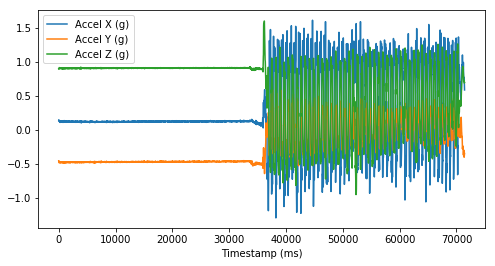

In [15]:
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

## HP Filter raw accelerometer data

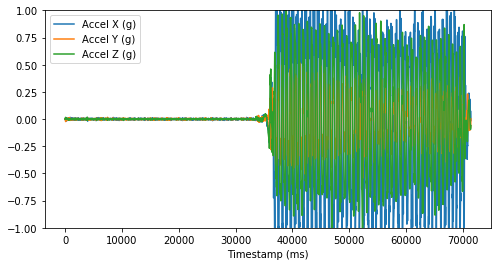

In [16]:
loc = 'dorsal_hand_left'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

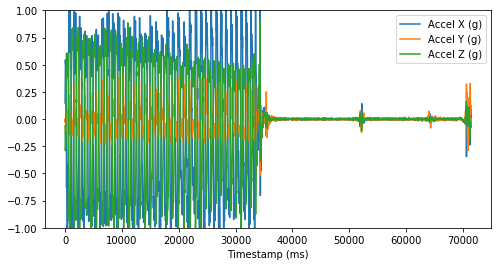

In [17]:
loc = 'dorsal_hand_right'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## BP filter (3-8 Hz) for tremor detection

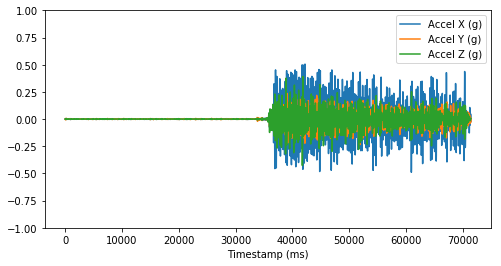

In [18]:
loc = 'dorsal_hand_left'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

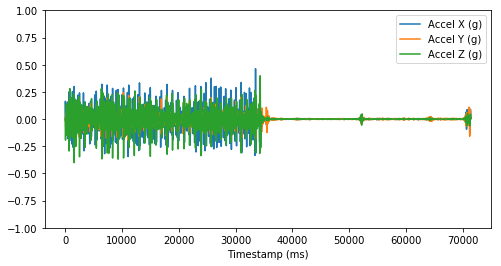

In [19]:
loc = 'dorsal_hand_right'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## Clip extraction

In [20]:
clip_data = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0,endTS=0.5)

Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 0
Motor #5: Alternating Hand Movements  sensortype = accel - trial 1
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 1
Motor #5: Alternating Hand Movements  sensortype = accel - trial 2
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 2
Motor #5: Alternating Hand Movements  sensortype = accel - trial 3
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 3
Motor #5: Alternating Hand Movements  sensortype = accel - trial 4
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 4
Motor #5: Alternating Hand Movements  sensortype = accel - trial 5
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 5
Motor #5: Alternating Hand Movements  sensortype = accel - trial 6
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 6


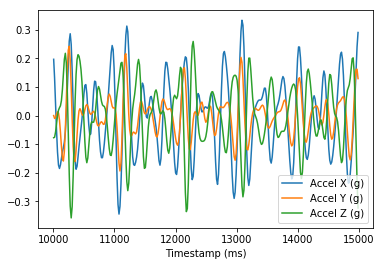

In [21]:
clip_data[0][sensor]['data'][2].plot()

### Separate clips data for left and right limb

In [22]:
clip_dataR = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0,endTS=0.5)
clip_dataL = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0.5,endTS=1)

Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 0
Motor #5: Alternating Hand Movements  sensortype = accel - trial 1
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 1
Motor #5: Alternating Hand Movements  sensortype = accel - trial 2
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 2
Motor #5: Alternating Hand Movements  sensortype = accel - trial 3
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 3
Motor #5: Alternating Hand Movements  sensortype = accel - trial 4
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 4
Motor #5: Alternating Hand Movements  sensortype = accel - trial 5
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 5
Motor #5: Alternating Hand Movements  sensortype = accel - trial 6
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 6
Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Mo

In [23]:
clip_dataL[1][sensor]['clip_len']

[4986, 4986, 4986, 4985, 4986, 4986, 4986]

## Feature extraction

Let's start with the following:
* Energy (total within segment)
* Max
* Min
* Mean
* Variance
* Skewness
* Kurtosis
* Cross-correlation 
    * peak
    * Time lag of peak
* Sample Entropy
    * raw signal
    * Power spectra
* Power spectra 1-10 Hz

In [24]:
feature_extraction(clip_data)

In [25]:
# clip_data[0][sensor]['features'].columns
# clip_data[0][sensor]['features']

In [26]:
# #TEST FEATURE SET ON RAW DATA

# #Energy of signal on each axis
# E = np.asarray(np.sum(rawdata**2,axis=0))

# #range on each axis
# min_xyz = np.min(rawdata,axis=0)
# max_xyz = np.max(rawdata,axis=0)
# r = np.asarray(max_xyz-min_xyz)

# #Moments on each axis
# mean = np.asarray(np.mean(rawdata,axis=0))
# var = np.asarray(np.std(rawdata,axis=0))
# sk = skew(rawdata)
# kurt = kurtosis(rawdata)

# #Pearson correlation between axes pairs
# r_xy = pearsonr(rawdata['Accel X (g)'].values,rawdata['Accel Y (g)'].values)
# r_xy = np.asarray([r_xy[0]])
# r_xz = pearsonr(rawdata['Accel X (g)'].values,rawdata['Accel Z (g)'].values)
# r_xz = np.asarray([r_xz[0]])
# r_yz = pearsonr(rawdata['Accel Y (g)'].values,rawdata['Accel Z (g)'].values)
# r_yz = np.asarray([r_yz[0]])

# #Cross-correlation between axes pairs
# xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
# xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
# xcorr_peak_xy = np.max(xcorr_xy)
# xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy)

# xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
# xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
# xcorr_peak_xz = np.max(xcorr_xz)
# xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

# xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
# xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
# xcorr_peak_yz = np.max(xcorr_yz)
# xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

# #pack xcorr features
# xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
# xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

# #sample entropy
# sH = []
# for a in range(3):
#     sH.append(nolds.sampen(rawdata.iloc[:,a]))
# # sh = np.asarray(sh)

# #Power of FFT between 1-10 Hz
# Pxx,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
# xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
# xfft = np.reshape(xfft,(1,xfft.size)) #row vector
# xfft = xfft.reshape(-1)

# #Assemble features in array
# x = np.concatenate((E,r,mean,var,sk,kurt,r_xy,r_xz,r_yz,xcorr_peak,xcorr_lag,sH,xfft))
# x = x.reshape(1,x.shape[0])
# print(x.shape)


** Plot power spectra from one clip **

In [27]:
nb = 11 #number of bins for power spectra

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9DCBA8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000019109780>], dtype=object)

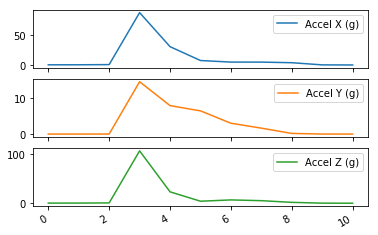

In [28]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=True) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9E4390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001B3BBC18>], dtype=object)

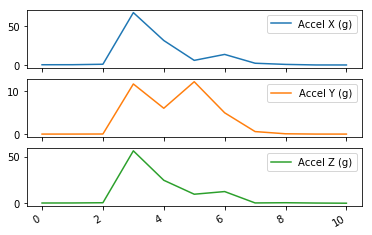

In [29]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9ED6D8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001B5D1C50>], dtype=object)

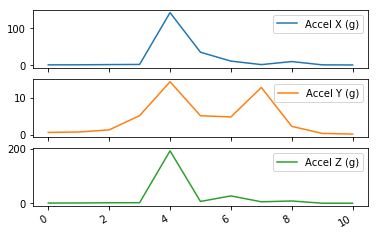

In [30]:
rawdata = clip_data[4][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

## Compute Power spectra with Welch method

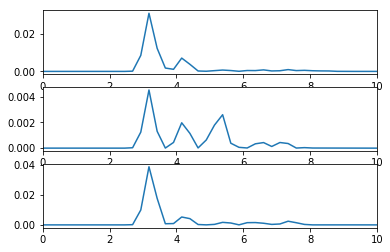

In [31]:
#signal features
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
fig = plt.figure()
# fp, ax_arr = plt.subplots(3, sharex=True)

for i in range(3):
    fig.add_subplot(3,1,i+1)
    x = rawdata.iloc[:,i]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=256)
    plt.plot(f,Pxx_den)
#     plt.semilogy(f,Pxx_den)
    plt.xlim([0,10])

In [32]:
feature_extraction(clip_data)

In [33]:
clip_data[1]['accel']['features']

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,4.643825,3.616207,9.287554,0.610735,0.588656,0.804825,-0.000064,-0.000940,0.001525,0.121805,...,0.225836,0.317844,8.300611,246.677536,29.203438,17.509050,7.991279,11.992510,0.378453,0.061520
1,10.405684,1.577836,13.267137,1.000330,0.373529,0.910593,0.001834,0.001282,-0.003389,0.182323,...,1.269315,1.088311,31.932907,81.991417,212.952606,9.442272,18.247858,2.231068,0.805700,0.195111
2,8.373985,3.284962,10.937361,0.948587,0.488759,0.869043,-0.000703,-0.001522,0.002182,0.163565,...,0.535047,1.625055,36.389404,130.837997,66.775871,12.435287,16.762491,5.238369,0.700042,0.028106
3,7.223465,4.008066,8.188945,0.999503,0.532606,0.870368,0.000316,0.000542,-0.001702,0.151915,...,0.369187,0.609011,8.981864,156.843506,43.012157,49.136074,15.647147,9.669178,0.624416,0.138703
4,8.832319,3.909850,21.082373,0.802633,0.650270,1.193025,-0.000165,-0.001173,0.003122,0.167983,...,1.326285,2.686092,97.933929,257.107880,160.655991,49.703709,48.618580,6.747800,0.715787,0.188830
5,7.601760,4.987590,28.567808,0.959934,0.599470,1.467395,-0.001139,0.001217,-0.002955,0.155838,...,1.515140,4.047810,60.252289,379.563232,83.540619,396.539520,36.639015,44.550388,5.518557,2.303737
6,5.728435,1.968680,17.760265,0.866116,0.486389,1.532289,0.000441,0.000014,0.001212,0.135283,...,0.351487,1.165644,12.749432,325.650421,63.537880,134.819824,42.598305,18.225355,2.611034,1.236131


# Aggregate features data with scores for given task - cycle through all subjects
for s in subjects:
*    load score files
*    load subject file
*    choose task and sensor location
*    extract clips
*    compute features on each trial
*    Aggregate subj code and score with feature matrix

**Note: gyro data has to be added **

In [34]:
??HPfilter

In [35]:
#aggreagate features (input) and metadata(output) for classification stage
#append is a flag on whether to create a new data matrix or aggregate new rows to existing one
#startTS and endTS specificies fraction of raw sensors data to use to generate clips
#side specificies which score side to use (recommended to use the same side of the loca)
#symptom specifies which filter to use. None only applies a HP filter to the data
def DataAggregator(task,task_scores,locs,side,clipsize=5000,overlap=0.5,startTS=0,endTS=1,append=1,symptom=None):
    

    #load subject scores (std motor assessments)
    mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
    #remove words:(Qxx) and 'rating' from each column for readability
    cols= mot_scores.columns
    cols = cols[4:]
    cols = cols.tolist()
    colsnew = [x.split('(')[0] for x in cols]
    colsnew = [x.strip() for x in colsnew] #remove whitspace
    colsnew = [x.split('rating')[0] for x in colsnew]
    colsnew = [x.strip() for x in colsnew]
    c = dict(zip(cols,colsnew))
    mot_scores = mot_scores.rename(index=str, columns=c)

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename for filename in d if filename.startswith('1')]
    print(fnames)
    print('Aggregating scores for %s side'%side)

    Data = pd.DataFrame() #the table with all data
    for subj_filename in fnames:

        #extract current subject scores and metadata
        subj = int(subj_filename[:4]) #subj code
        #extract scores for corresponding task, subject and side
        subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                                    task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                    task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                                    task_scores+ ' ' + 'overall score']]       
        #change 1 month label to 4 wks for proper sorting
        mot_scores.loc[mot_scores['Visit']=='1 Month','Visit']='4 Weeks'
        #rename cols
        subj_score = subj_score.rename(index=str,
                                       columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor', 
                                               subj_score.columns[4]:'overall'})

        subj_score.index = range(len(subj_score))
        if len(subj_score) < 1:
            print('no scores data for subject %d -- skipping..'%subj)

        #load subject sensor data Pickle file (dictionary)
        else:
            f = open(os.path.join(dict_path,subj_filename),'rb')    
            act_dict = pickle.load(f)
            f.close()
            print('\nLoaded Subj %s sensor data'%subj)

            #loop through sensor locations
            for loc in locs:
                print(loc)

                #high pass filter accelerometer data
                HPfilter(act_dict,task,loc)
                #additional symptom-specific filters
                if symptom == 'tremor':
                    BPfilter(act_dict,task,loc)
                    print('applying Band-pass filter')
                if symptom == 'bradykinesia':
                    HPfilter(act_dict,task,loc,cutoff=3,ftype='lowpass')
                    print('applying Low-pass filter')
                    
                #generate clips and extract features
                clip_data = gen_clips(act_dict,task,loc,clipsize,overlap,False,startTS,endTS)
                feature_extraction(clip_data)

                #aggreagate subject, scores and features data
                n_visits = len(subj_score)    #of visits in Database
                n_rec = len(clip_data.keys()) #of sensor recordings
                print('n_visits in score file = %d, # recordings = %d, location: %s'%(n_visits,n_rec,loc))
                N = n_visits

                if n_visits != n_rec:
                    print('# of recordings does not match # of visits! - matching first %d recordings'%(min([n_visits,n_rec])))
                    N = min([n_visits,n_rec])

                #aggregate data from each visit for current subject
                for i in range(N):
                    #features
                    D = clip_data[i]['accel']['features']
                    featcols = D.columns.tolist()
                    #scores
                    D['Bradykinesia'] = subj_score['Bradykinesia'][i]
                    D['Tremor'] = subj_score['Tremor'][i]
                    #metadata
                    D['Visit'] = subj_score.Visit[i] 
                    D['Task'] = task
                    D['Location'] = loc 
                    D['Subject'] = subj
                    Data = pd.concat([Data,D]) #concatenate data from each visit

    cols = ['Subject','Visit','Task','Location','Bradykinesia','Tremor']+ featcols
    Data = Data[cols]    
    print('\nData matrix generated')
    print(Data.shape)

    #save data to feature matrix
    if symptom == None:
        symptom=''
    saved_filename = 'Data'+symptom+'.csv'
    if append and os.path.isfile(os.path.join(features_path,saved_filename)):
        Data.to_csv(os.path.join(features_path,saved_filename),mode='a+',header=False) #append to existing
        print('Appending to existing Feature matrix ' + str(os.path.join(features_path,saved_filename)))    
            
    else:
        Data.to_csv(os.path.join(features_path,saved_filename))
        print('Feature matrix saved in ' + str(os.path.join(features_path,saved_filename)))
    
#     return Data

In [36]:
task = 'Motor #5: Alternating Hand Movements'
task_scores = 'Alternating left hand movements' #name of task in scores sheet
locs = ['dorsal_hand_left'] #sensor location
side = 'left' #score side to use (use same as sensor side)

In [37]:
DataAggregator(task,task_scores,locs,side,startTS=0.5,endTS=1,append=1,symptom='bradykinesia')

['1004dict.pkl', '1018dict.pkl', '1052dict.pkl', '1047dict.pkl', '1044dict.pkl', '1016dict.pkl', '1049dict.pkl', '1032dict.pkl', '1038dict.pkl', '1024dict.pkl', '1020dict.pkl', '1019dict.pkl', '1051dict.pkl', '1030dict.pkl', '1046dict.pkl', '1029dict.pkl']
Aggregating scores for left side

Loaded Subj 1004 sensor data
dorsal_hand_left
applying Low-pass filter
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left

Loaded Subj 1018 sensor data
dorsal_hand_left
applying Low-pass filter
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
no scores data for subject 1052 -- skipping..

Loaded Subj 1047 sensor data
dorsal_hand_left
applying Low-pass filter
n_visits in score file = 6, # recordings = 7, location: dorsal_hand_left
# of recordings does not match # of visits! - matching first 6 recordings

Loaded Subj 1044 sensor data
dorsal_hand_left
applying Low-pass filter
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left

Loaded Su

In [41]:
#load Pickle file dict
subj = 1029
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

## Trial 1

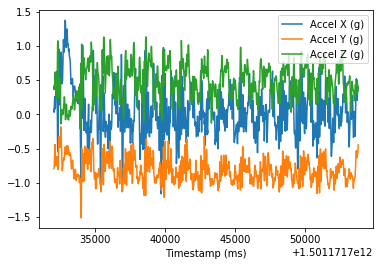

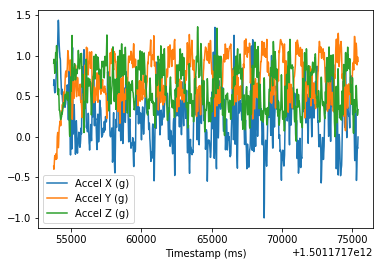

In [83]:
idx = len(act_dict['Motor #4: Finger to Nose'][0]['dorsal_hand_right']['accel'])
idx/2
plot_data(act_dict,'Motor #4: Finger to Nose',0,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',0,'dorsal_hand_left','accel',idx//2,idx)

## Trial 2

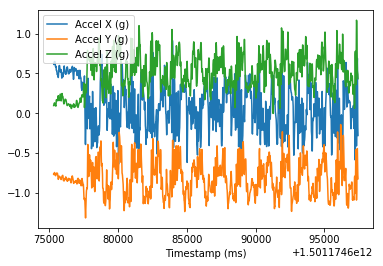

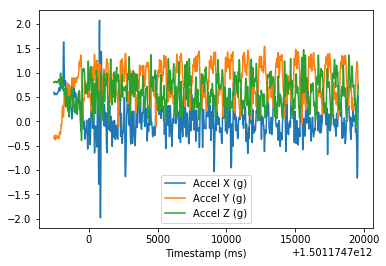

In [86]:
idx = len(act_dict['Motor #4: Finger to Nose'][1]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',1,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',1,'dorsal_hand_left','accel',idx//2,idx)

## Trial 3

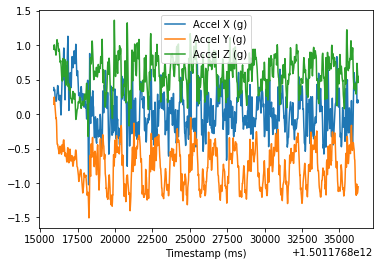

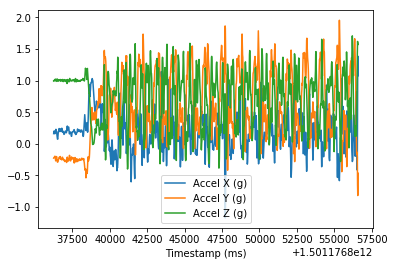

In [87]:
idx = len(act_dict['Motor #4: Finger to Nose'][2]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',2,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',2,'dorsal_hand_left','accel',idx//2,idx)

## Trial 4

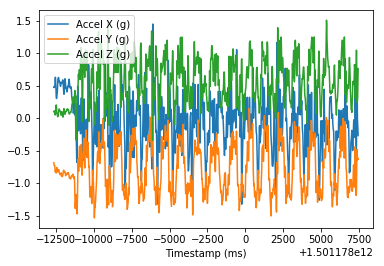

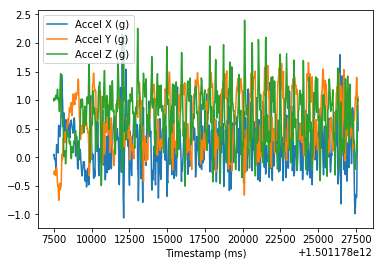

In [88]:
idx = len(act_dict['Motor #4: Finger to Nose'][3]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',3,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',3,'dorsal_hand_left','accel',idx//2,idx)

## Trial 5

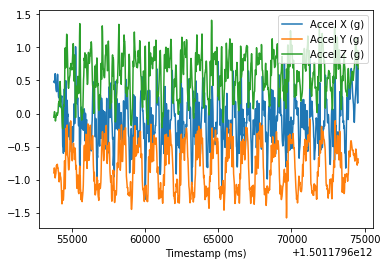

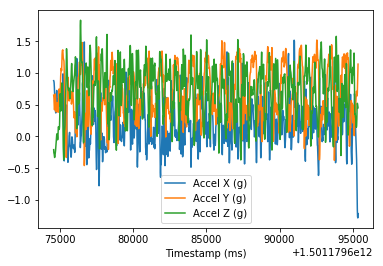

In [89]:
idx = len(act_dict['Motor #4: Finger to Nose'][4]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',4,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',4,'dorsal_hand_left','accel',idx//2,idx)

## Trial 6

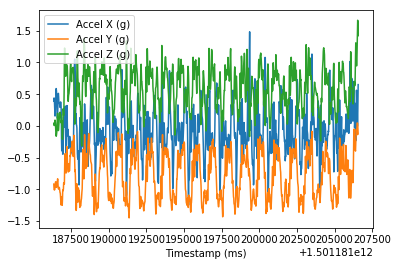

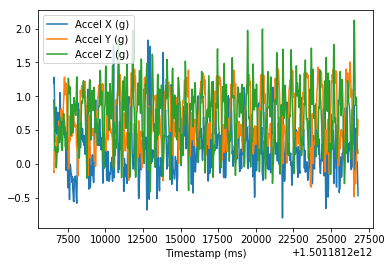

In [90]:
idx = len(act_dict['Motor #4: Finger to Nose'][5]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',5,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',5,'dorsal_hand_left','accel',idx//2,idx)

## Day 2 Data

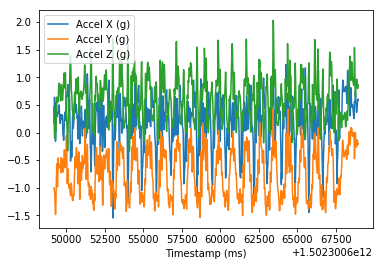

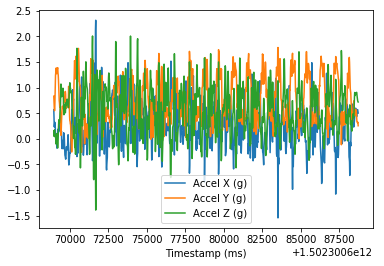

In [91]:
idx = len(act_dict['Motor #4: Finger to Nose'][6]['dorsal_hand_right']['accel'])
plot_data(act_dict,'Motor #4: Finger to Nose',6,'dorsal_hand_right','accel',0,idx//2)
plot_data(act_dict,'Motor #4: Finger to Nose',6,'dorsal_hand_left','accel',idx//2,idx)

# The sections below are deprecated and will be moved to Models.ipynb

## Organize target scores into array

In [38]:
#rows with symptoms (Dataset w both hands)
indpL = ((Data['Bradykinesia left']>0)&(Data['Location']=='dorsal_hand_left'))
indpR = ((Data['Bradykinesia right']>0)&(Data['Location']=='dorsal_hand_right'))
indp = indpL|indpR
indp = indp.values

NameError: name 'Data' is not defined

In [ ]:
#rows with symptoms (Dataset w one hand)
indp = (Data['Bradykinesia left']>0) # | (Data['Bradykinesia right']>0)
indp = indp.values

In [ ]:
indn = (Data['Bradykinesia left']==0) & (Data['Bradykinesia right']==0) & (Data['Tremor left']==0) &(Data['Tremor right']==0) #no symptom
indn = indn.values #1 = no symptom

In [ ]:
print('Rows w bradykinesia %d/%d, Rows w no symptoms %d/%d'%(sum(indp),len(indp),sum(indn),len(indn)))
print('Rows w bradykinesia %d/%d, Rows w no bradykinesia %d/%d'%(sum(indp),len(indp),sum(~indp),len(indp)))

# PCA on features to visualize subjects with bradykinesia


In [ ]:
#load feature matrix
Data = pd.read_csv(os.path.join(features_path,'Data.csv'))
print(Data.shape)

In [ ]:
Data.head()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [ ]:
#standardize features
X = Data.iloc[:,8:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

In [ ]:
%matplotlib inline
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
ax = plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [ ]:
Xpca.shape

In [ ]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[indn,0],Xpca[indn,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No symptom')
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label='Bradykinesia')
plt.legend()

In [ ]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No Bradykinesia')
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label='Bradykinesia')
plt.legend()

# Fit an LDA to the data

In [ ]:
y = indp.astype(int) #label values
X_std.shape
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_std,y)
fig=plt.figure()
plt.plot(X_lda[~indp],np.zeros((X_lda[~indp].shape[0],1)),'.')
plt.plot(X_lda[indp],np.ones((X_lda[indp].shape[0],1)),'r.')
plt.xlabel('LDA feature')
plt.ylabel('Bradykinesia presence')
# X_lda_df = pd.DataFrame(data=np.hstack((X_lda,indp)),columns=['lda_feature','bradykinesia'])
# X_lda_df.head()

# Fit some classifiers to data using LOSOCV

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

### Helper fcns

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Bradykinesia','No-symptom'], rotation=45)
    plt.yticks(tick_marks, ['Bradykinesia','No-symptom'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; acc_all=[] #sens and spec for current model and all subject
        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
            else:
                print('%s has no positive examples'%Data.Subject[test_index].unique())
                Sens = np.nan
            if np.sum(yte==0)>0:
                Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
            else:
                Spec = np.nan
                print('%s has no negative examples'%Data.Subject[test_index].unique())
            Sens_all.append(Sens); Spec_all.append(Spec)
            #compute accuracy
            acc = sum(ypred==yte)/len(yte)
            acc_all.append(acc)
        
        #mean across all subjects
        print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
        print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
        print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
        

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [ ]:
Data.Subject.unique()

In [ ]:
#LOSO CV
groups = Data.Subject.as_matrix()

In [ ]:
models = [LogisticRegression(penalty='l1',random_state=2),
          RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='linear',C=1,cache_size=800,probability=True,random_state=3),
         ]
model_name = ['LR','Random Forest','Gradient Boosting','SVM']
models = list(zip(models,model_name))
# models_list = list(models) #to save it as a list

In [ ]:
y = indp.astype(int) #target 

In [ ]:
LOSOCV(Data,X_std,y,groups,models)

# MISC STUFF - To Clean/Remove

## Tests on individual subjects / features

In [ ]:
#load subject scores
#path = '../Scores/'
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))

In [ ]:
mot_scores[mot_scores['Subject']==1016].head(3)

In [ ]:
subj = 1016
#extract scores for corresponding task 
task = 'Motor #8: Typing on a Computer'
loc = 'dorsal_hand_right'

subj=1016
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                 'Typing on a computer keyboard overall score (Q92)',
#                 'Typing on a computer keyboard bradykinesia left upper limb rating (Q93)',
#                 'Typing on a computer keyboard tremor left upper limb rating (Q97)',
                'Typing on a computer keyboard bradykinesia right upper limb rating (Q94)',
                'Typing on a computer keyboard tremor right upper limb rating (Q98)']]

subj_score = subj_score.rename(index=str,columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right' })
subj_score.index = range(len(subj_score))
subj_score

In [ ]:
#aggreagate subject, scores and features data
Data = pd.DataFrame()
D = pd.DataFrame()

n_visits = len(subj_score)    # # of visits in Database
n_rec = len(clip_data.keys()) # # of sensor recordings
print('n_visits = %d, # recordings = %d'%(n_visits,n_rec))
N = n_visits

if n_visits != n_rec:
    print('# of recordings does not match # of visits! - matching first %d recordings')%(min([n_visits,n_rec]))
    N = min([n_visits,n_rec])

for i in range(N):
    #features
    D = clip_data[i]['accel']['features']
    featcols = D.columns.tolist()
    #scores
    D['Bradykinesia right'] = subj_score['Bradykinesia right'][i]
    D['Tremor right'] = subj_score['Tremor right'][i]
    #metadata
    D['Visit'] = subj_score.Visit[i] 
    D['Task'] = task
    D['Location'] = loc 
    Data = pd.concat([Data,D]) #concatenate data from each visit
    
Data['Subject'] = subj 
cols = ['Subject','Visit','Task','Location','Bradykinesia right','Tremor right']+ featcols
Data = Data[cols]    
    

In [ ]:
D.columns

In [ ]:
Data_acc = clip_data[0]['accel']['features']
Data_gyr = clip_data[0]['accel']['features']
print(Data_acc.shape,Data_gyr.shape)
Data = pd.concat([Data_acc,Data_gyr],axis=1)
print(Data.shape)

# Visualize different tasks

In [ ]:
act_dict.keys()

In [ ]:
act_dict['Motor #10: Drinking Water'][0].keys()

In [ ]:
tasks= ['Motor #13: Sitting','Motor #6: Sit to Stand','Motor #2: Walking','Motor #8: Typing on a Computer','Motor #4: Finger to Nose']
trials = [0,5]
# locs = ['dorsal_hand_right','flexor_digitorum_right','sacrum','anterior_thigh_right']
# sensor = ['accel','gyro']

In [ ]:
p = product(tasks,trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],'anterior_thigh_right','accel')
    plt.title(t)

In [ ]:
#test itertools
from itertools import product
t = ('T1','T2')
l = (1,2)
s = ('s1','s2')
# print(list(product(t,l,s)))
taskslist = list(product(t,l,s))
for t in taskslist:
    print(t)

In [ ]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','accel')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','accel')


In [ ]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','gyro')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','gyro')

In [ ]:
errordf = pd.read_excel(r'X:\CIS-PD Study\PD_errorWorkbook.xlsx')
errPar = errordf[errordf['Participant'] == 1020]
errorActivity = (errPar['Activity'])
error = errPar['Error']
cycle = errPar['Cycle']
day = errPar['Day']
time = errPar['Time Adjusted (sec)']
desc = errPar['Type']
errorAndActivity = errPar[['Error','Activity']]
# Add dynamic path for participant
#testPath = r'X:\CIS-PD Study\Subjects\1038'
#(timestamps,random) = process_annotations(testPath)
#pd.options.display.max_rows = 999
#timestamps = fix_errors(1038)
#timestamps